# IMDA Dataset processing

In [22]:
import os
import re
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore')

## load results

In [2]:
rule_based_result_df = pd.read_excel("../data/processed/IMDA_V2_Sentiment_label_0812.xlsx")
rule_based_result_df = rule_based_result_df.drop(columns=['Unnamed: 0'])
rule_based_result_df = rule_based_result_df.fillna(0)
rule_based_result_df = rule_based_result_df.drop_duplicates(subset=['cleaned_text_for_sentiment'])
rule_based_result_df = rule_based_result_df.drop(columns=['V-1', 'T-1', 'S-1'])
rule_based_result_df.head()

,file_name,session_id,speaker_id,speaker_type,dialog_type,x_min,x_max,text,cleaned_text_for_sentiment,word_count,...,S-6,V-8,T-8,S-8,V-9,T-9,S-9,Manual,Unnamed: 35,processed_text
0,app_0683_0013_phnd_cc-bnk.TextGrid,683,13,agent,bank,2.48,5.35,hi this is A B C bank how can I help you,hi this is A B C bank how can I help you,12,...,0.0,0.4019,0.0,0.0,0.4019,0.0,0.0,0.0,0.0,hi be A B C bank how can help
1,app_0683_4366_phnd_cc-bnk.TextGrid,683,4366,client,bank,5.35,15.42,hi my name is john (uh) I'm calling in with in...,hi my name is john (uh) I'm calling in with in...,20,...,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,hi name be john call in with in regard of enqu...
2,app_0683_0013_phnd_cc-bnk.TextGrid,683,13,agent,bank,17.15,23.55,ya our bank (uh) do give out ya our bank does ...,ya our bank (uh) do give out ya our bank does ...,9,...,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,our bank do give out our bank do give out home...
3,app_0683_4366_phnd_cc-bnk.TextGrid,683,4366,client,bank,17.20,20.05,sorry does does your bank give out home loans,sorry does does your bank give out home loans,8,...,0.0,-0.0772,-0.5,0.0,-0.0772,-0.5,0.0,0.0,0.0,sorry do do bank give out home loan
4,app_0683_4366_phnd_cc-bnk.TextGrid,683,4366,client,bank,23.28,27.41,[oh] ya probably I can give you some informati...,[oh] ya probably I can give you some informati...,11,...,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,probably can give some information on on side


In [3]:
rule_based_result_df.shape, rule_based_result_df.columns

((84327, 33),
 Index(['file_name', 'session_id', 'speaker_id', 'speaker_type', 'dialog_type',
        'x_min', 'x_max', 'text', 'cleaned_text_for_sentiment', 'word_count',
        'duration', 'qualified_for_sentiment', 'V-2', 'T-2', 'S-2', 'V-3',
        'T-3', 'S-3', 'V-5', 'T-5', 'S-5', 'V-6', 'T-6', 'S-6', 'V-8', 'T-8',
        'S-8', 'V-9', 'T-9', 'S-9', 'Manual', 'Unnamed: 35', 'processed_text'],
       dtype='object'))

In [4]:
rule_based_result_df = rule_based_result_df[rule_based_result_df.speaker_type=='client']

In [5]:
rule_based_result_df[['V-5', 'T-5', 'S-5','V-9', 'T-9', 'S-9']].describe().round(3)

,V-5,T-5,S-5,V-9,T-9,S-9
count,38273.000,38273.000,38273.000,38273.000,38273.000,38273.000
mean,0.288,0.175,-0.093,0.303,0.189,-0.089
std,0.341,0.252,0.484,0.331,0.247,0.492
min,-0.970,-1.000,-1.000,-0.970,-1.000,-1.000
25%,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.273,0.143,0.000,0.296,0.167,0.000
75%,0.557,0.393,0.000,0.572,0.400,0.000
max,0.977,1.000,1.000,0.980,1.000,1.000


In [6]:
# Extracting the VADER, TextBlob, and Stanza columns for comparison
vader_columns = [col for col in rule_based_result_df.columns if col.startswith('V-')]
textblob_columns = [col for col in rule_based_result_df.columns if col.startswith('T-')]
stanza_columns = [col for col in rule_based_result_df.columns if col.startswith('S-')]

In [7]:
# Define the sentiment classification function based on the provided thresholds
def classify_sentiment_vader(score):
    if -0.05 <= score <= 0.5:
        return 'neutral'
    elif score > 0.5:
        return 'positive'
    else:
        return 'negative'

def classify_sentiment_textblob(score):
    if -0.05 <= score <= 0.3:
        return 'neutral'
    elif score > 0.3:
        return 'positive'
    else:
        return 'negative'

def classify_sentiment_stanza(score):
    # Since no specific threshold is provided, let's assume a default for demonstration
    if -0.05 <= score <= 0.05:
        return 'neutral'
    elif score > 0.05:
        return 'positive'
    else:
        return 'negative'

# Apply classification to each sentiment analysis method
for col in vader_columns:
    rule_based_result_df[f'{col}_sentiment'] = rule_based_result_df[col].apply(classify_sentiment_vader)

for col in textblob_columns:
    rule_based_result_df[f'{col}_sentiment'] = rule_based_result_df[col].apply(classify_sentiment_textblob)

for col in stanza_columns:
    rule_based_result_df[f'{col}_sentiment'] = rule_based_result_df[col].apply(classify_sentiment_stanza)


/var/folders/jv/1vv6tgys3bzf7drmcnhh7q2m0000gn/T/ipykernel_58006/1788247289.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rule_based_result_df[f'{col}_sentiment'] = rule_based_result_df[col].apply(classify_sentiment_vader)
/var/folders/jv/1vv6tgys3bzf7drmcnhh7q2m0000gn/T/ipykernel_58006/1788247289.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rule_based_result_df[f'{col}_sentiment'] = rule_based_result_df[col].apply(classify_sentiment_vader)
/var/folders/jv/1vv6tgys3bzf7drmcnhh7q2m0000gn/T/ipy

### Plots

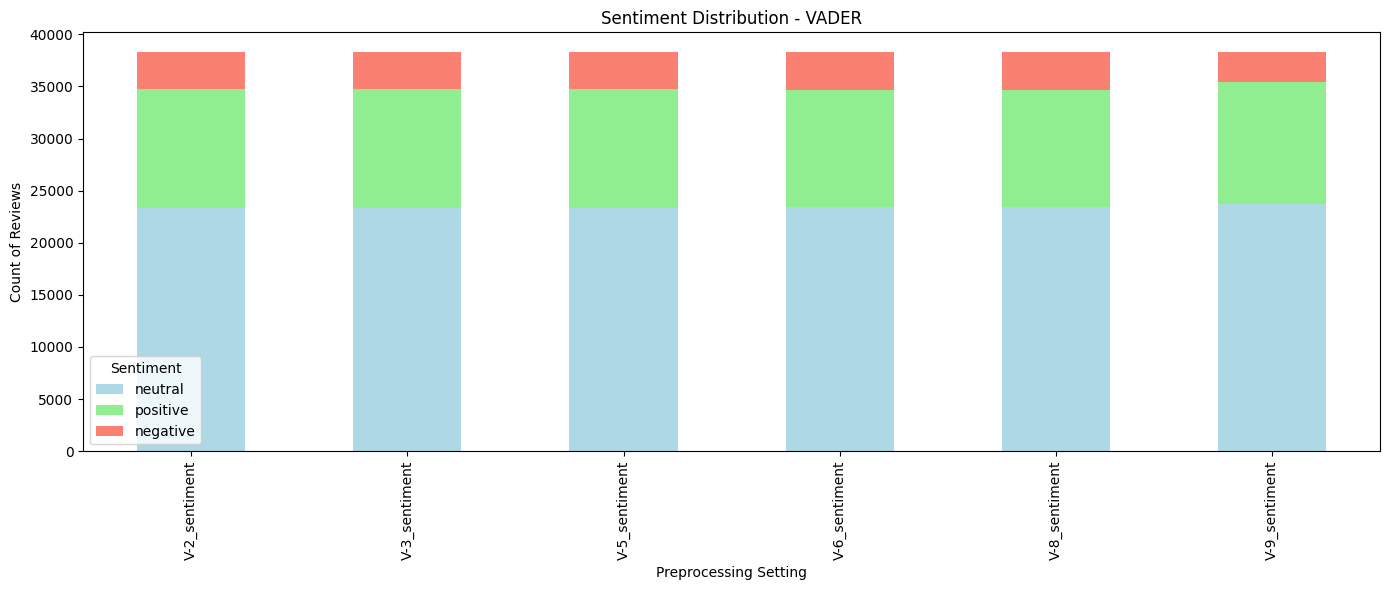

In [8]:
import matplotlib.pyplot as plt
# Calculate the sentiment distribution for each method
vader_distribution = rule_based_result_df[[f'{col}_sentiment' for col in vader_columns]].apply(pd.Series.value_counts)
textblob_distribution = rule_based_result_df[[f'{col}_sentiment' for col in textblob_columns]].apply(pd.Series.value_counts)
stanza_distribution = rule_based_result_df[[f'{col}_sentiment' for col in stanza_columns]].apply(pd.Series.value_counts)

# Plot the sentiment distribution for VADER
vader_distribution.T.plot(kind='bar', stacked=True, figsize=(14, 6), color=['lightblue', 'lightgreen', 'salmon'])
plt.title('Sentiment Distribution - VADER')
plt.xlabel('Preprocessing Setting')
plt.ylabel('Count of Reviews')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


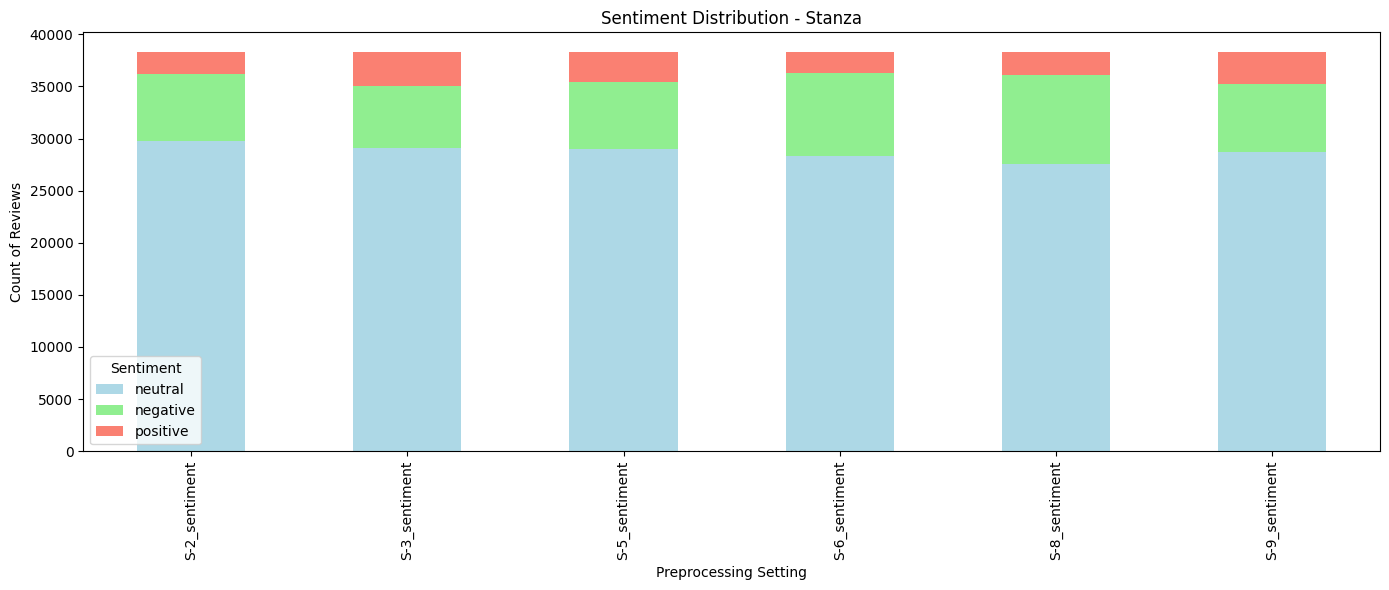

In [9]:
# Plot the sentiment distribution for Stanza
stanza_distribution.T.plot(kind='bar', stacked=True, figsize=(14, 6), color=['lightblue', 'lightgreen', 'salmon'])
plt.title('Sentiment Distribution - Stanza')
plt.xlabel('Preprocessing Setting')
plt.ylabel('Count of Reviews')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

In [10]:
# Extracting the count of positive and negative instances across methods
vader_pos_neg = vader_distribution.loc[['positive', 'negative']]
textblob_pos_neg = textblob_distribution.loc[['positive', 'negative']]
stanza_pos_neg = stanza_distribution.loc[['positive', 'negative']]

# Settings labels
settings_labels = ['2', '3', '5', '6', '8', '9']

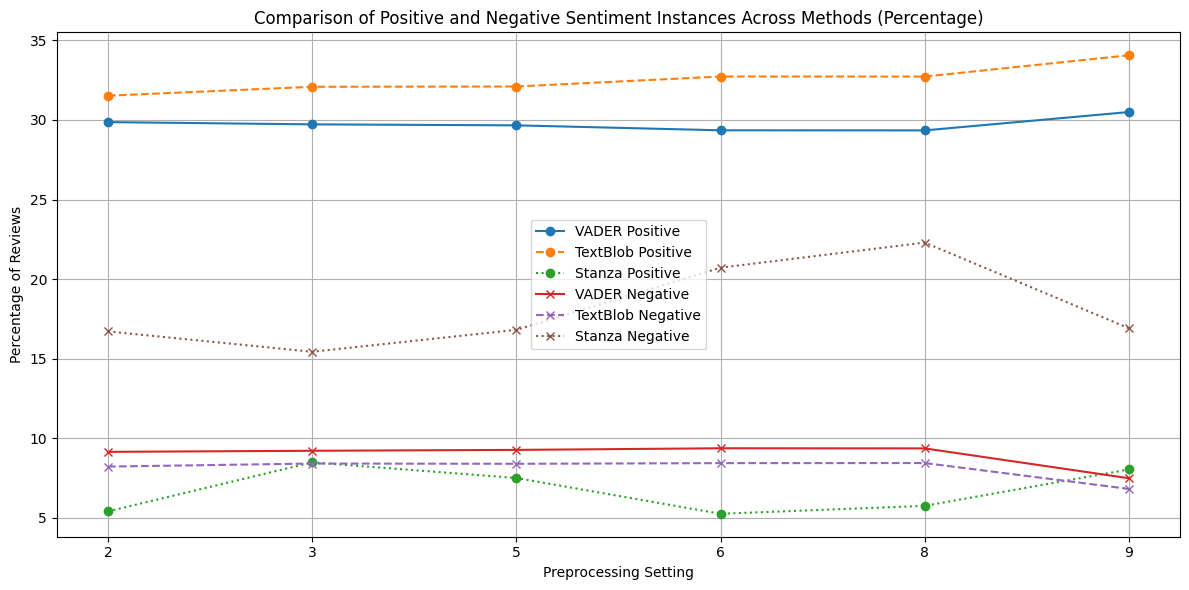

In [11]:
# Calculate the total number of reviews for normalization
total_reviews = len(rule_based_result_df)

# Normalize the positive and negative counts to percentages
vader_pos_neg_percent = (vader_pos_neg / total_reviews) * 100
textblob_pos_neg_percent = (textblob_pos_neg / total_reviews) * 100
stanza_pos_neg_percent = (stanza_pos_neg / total_reviews) * 100

# Plotting the line chart for percentage of positive and negative instances
plt.figure(figsize=(12, 6))

# Positive Instances Percentage
plt.plot(settings_labels, vader_pos_neg_percent.loc['positive'], marker='o', label='VADER Positive')
plt.plot(settings_labels, textblob_pos_neg_percent.loc['positive'], marker='o', linestyle='--', label='TextBlob Positive')
plt.plot(settings_labels, stanza_pos_neg_percent.loc['positive'], marker='o', linestyle=':', label='Stanza Positive')

# Negative Instances Percentage
plt.plot(settings_labels, vader_pos_neg_percent.loc['negative'], marker='x', label='VADER Negative')
plt.plot(settings_labels, textblob_pos_neg_percent.loc['negative'], marker='x', linestyle='--', label='TextBlob Negative')
plt.plot(settings_labels, stanza_pos_neg_percent.loc['negative'], marker='x', linestyle=':', label='Stanza Negative')

plt.title('Comparison of Positive and Negative Sentiment Instances Across Methods (Percentage)')
plt.xlabel('Preprocessing Setting')
plt.ylabel('Percentage of Reviews')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Voting

In [12]:
# Map the sentiment labels to integers
label_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
# Apply classification to each sentiment analysis method
for col in vader_columns + textblob_columns + stanza_columns:
    rule_based_result_df[f'{col}_vote'] = rule_based_result_df[col + '_sentiment'].map(label_mapping)

vote_columns = [col for col in rule_based_result_df.columns if col.endswith('_vote')]
# Calculate the total votes for each review
rule_based_result_df['sum_score'] = rule_based_result_df[vote_columns].sum(axis=1)

In [13]:
# Calculate the maximum frequency and identify the corresponding sentiment
def determine_max_sentiment(pos_count, neg_count, neu_count):
    max_frequency = max(pos_count, neg_count, neu_count)
    
    if max_frequency == pos_count and pos_count > max(neg_count, neu_count):
        return 'positive', max_frequency
    elif max_frequency == neg_count and neg_count > max(pos_count, neu_count):
        return 'negative', max_frequency
    elif max_frequency == neu_count and neu_count > max(neg_count, pos_count):
        return 'neutral', max_frequency
    else:
        return 'tie', max_frequency

# Function to calculate the highest frequency of a value in a row
def calculate_highest_frequency(row):
    # Count the occurrences of each vote
    pos_count = sum(row[col] == 1 for col in vote_columns)
    neg_count = sum(row[col] == -1 for col in vote_columns)
    neu_count = sum(row[col] == 0 for col in vote_columns)
    
    max_sentiment, max_frequency = determine_max_sentiment(pos_count, neg_count, neu_count)
    return max_sentiment, max_frequency


rule_based_result_df[['final_sentiment', 'max_agreement_votes']] = rule_based_result_df.apply(
    lambda row: calculate_highest_frequency(row), axis=1, result_type='expand'
)

rule_based_result_df[vote_columns + ['final_sentiment', 'max_agreement_votes']].head()

,V-2_vote,V-3_vote,V-5_vote,V-6_vote,V-8_vote,V-9_vote,T-2_vote,T-3_vote,T-5_vote,T-6_vote,T-8_vote,T-9_vote,S-2_vote,S-3_vote,S-5_vote,S-6_vote,S-8_vote,S-9_vote,final_sentiment,max_agreement_votes
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,neutral,18
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,0,0,negative,12
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,neutral,18
5,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,0,0,-1,neutral,15
6,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,neutral,13


In [16]:
# Sort the dataframe by agreement score in descending order
df_sorted = rule_based_result_df.sort_values(by='max_agreement_votes', ascending=False)

# Select a balanced subset
# Define how many records to take for each class
subset_size = 1000

balanced_subset = pd.concat([
    df_sorted[df_sorted['final_sentiment'] == 'positive'].head(subset_size),
    df_sorted[df_sorted['final_sentiment'] == 'neutral'].head(subset_size),
    df_sorted[df_sorted['final_sentiment'] == 'negative'].head(subset_size)
])


balanced_subset_distribution = balanced_subset.groupby(by=['final_sentiment','max_agreement_votes'])['V-2'].count()
balanced_subset_distribution

final_sentiment  max_agreement_votes
negative         12                      430
                 13                       78
                 14                       71
                 15                      116
                 16                       47
                 17                       69
                 18                      189
neutral          18                     1000
positive         15                      110
                 16                      210
                 17                      190
                 18                      490
Name: V-2, dtype: int64

In [17]:
df_sorted.groupby(by=['final_sentiment','max_agreement_votes'])['V-2'].count()

final_sentiment  max_agreement_votes
negative         7                        59
                 8                       126
                 9                       215
                 10                      268
                 11                      352
                 12                      829
                 13                       78
                 14                       71
                 15                      116
                 16                       47
                 17                       69
                 18                      189
neutral          7                       315
                 8                       326
                 9                       900
                 10                     1264
                 11                     1113
                 12                     7885
                 13                     1022
                 14                      979
                 15                     2360
                 1

In [21]:
df_sorted.groupby(by=['final_sentiment'])['session_id'].nunique()

final_sentiment
negative    655
neutral     660
positive    660
tie         658
Name: session_id, dtype: int64

In [18]:
sentiment_columns = []
for col in vader_columns + textblob_columns + stanza_columns:
    sentiment_columns.append(f'{col}_sentiment')

columns_dropped = vote_columns + sentiment_columns + ['Unnamed: 35']
balanced_subset_export = balanced_subset.drop(columns=columns_dropped)
balanced_subset_export.columns

Index(['file_name', 'session_id', 'speaker_id', 'speaker_type', 'dialog_type',
       'x_min', 'x_max', 'text', 'cleaned_text_for_sentiment', 'word_count',
       'duration', 'qualified_for_sentiment', 'V-2', 'T-2', 'S-2', 'V-3',
       'T-3', 'S-3', 'V-5', 'T-5', 'S-5', 'V-6', 'T-6', 'S-6', 'V-8', 'T-8',
       'S-8', 'V-9', 'T-9', 'S-9', 'Manual', 'processed_text', 'sum_score',
       'final_sentiment', 'max_agreement_votes'],
      dtype='object')

In [19]:
balanced_subset_export.shape

(3000, 35)

In [20]:
df_sorted.to_excel("../data/processed/IMDA_V2_Sentiment_label_0814_processed_voting_client_only.xlsx", index=False)

In [21]:
balanced_subset_export.to_excel(
    "../data/processed/IMDA_V2_Sentiment_label_0814_balanced_selection_client_only.xlsx", sheet_name='balanced_selection_3000', index=False)

## Choose another 3000

In [23]:
df_sorted.head()

,file_name,session_id,speaker_id,speaker_type,dialog_type,x_min,x_max,text,cleaned_text_for_sentiment,word_count,...,T-9_vote,S-2_vote,S-3_vote,S-5_vote,S-6_vote,S-8_vote,S-9_vote,sum_score,final_sentiment,max_agreement_votes
1,app_0683_4366_phnd_cc-bnk.TextGrid,683,4366,client,bank,5.35000,15.42000,hi my name is john (uh) I'm calling in with in...,hi my name is john (uh) I'm calling in with in...,20,...,0,0,0,0,0,0,0,0,neutral,18
40207,app_0997_4994_phnd_cc-bnk.TextGrid,997,4994,client,bank,9.97569,16.32688,hi I'm actually looking (uh) hi I'm mia I'm ac...,hi I'm actually looking (uh) hi I'm mia I'm ac...,11,...,0,0,0,0,0,0,0,0,neutral,18
40221,app_0997_4994_phnd_cc-bnk.TextGrid,997,4994,client,bank,276.37737,282.49231,I see that sounds really great so is there a c...,I see that sounds really great so is there a c...,20,...,1,1,1,1,1,1,1,18,positive,18
40234,app_0997_4994_phnd_cc-bnk.TextGrid,997,4994,client,bank,522.38375,531.66237,cool ya that sounds great actually (um) (ppo) ...,cool ya that sounds great actually (um) (ppo) ...,21,...,1,1,1,1,1,1,1,18,positive,18
40237,app_0997_4994_phnd_cc-bnk.TextGrid,997,4994,client,bank,563.93719,569.80638,[oh] so it'll be delivered to my house that's ...,[oh] so it'll be delivered to my house that's ...,10,...,1,1,1,1,1,1,1,18,positive,18


In [25]:
balanced_subset2 = pd.concat([
    df_sorted[df_sorted['final_sentiment'] == 'positive'].iloc[subset_size:2*subset_size].head(subset_size),
    df_sorted[df_sorted['final_sentiment'] == 'neutral'].iloc[subset_size:2*subset_size].head(subset_size),
    df_sorted[df_sorted['final_sentiment'] == 'negative'].iloc[subset_size:2*subset_size].head(subset_size)
])

balanced_subset2.to_excel(
    "../data/processed/IMDA_V2_Sentiment_label_0817_balanced_selection_client.xlsx", sheet_name='balanced_selection_next_3000', index=False)

In [28]:
balanced_subset2.shape == balanced_subset.shape

True